# Exploratory Data Analysis
This is an analysis of the harmonized but not further preprocessed datasets.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch, Rectangle
from matplotlib_venn import venn3, venn3_circles
import seaborn as sns

## Prepare and Load Datasets

In [ ]:
# Define paths
BASE_PATH = "../"  # Parent directory of current working directory
INPUT_DIR = os.path.join(BASE_PATH, "datasets/original_harmonized")
OUTPUT_DIR = os.path.join(BASE_PATH, "datasets/merged_by_task")

def load_and_merge_data(task, dataset, debug=False):
    """
    Load and merge dynamic, static, and outcome data for a specific task and dataset.

    Parameters:
    - task: Task name (e.g., 'aki', 'mortality', 'sepsis')
    - dataset: Dataset name (e.g., 'miiv', 'eicu', 'hirid')
    - debug: If True, only use the first 100 rows for faster development

    Returns:
    - A DataFrame with merged data including a dataset identifier column
    """
    # Construct the full folder path
    folder_path = os.path.join(INPUT_DIR, task, dataset)

    # Load each dataset
    dyn = pd.read_parquet(os.path.join(folder_path, "dyn.parquet"))
    outc = pd.read_parquet(os.path.join(folder_path, "outc.parquet"))
    sta = pd.read_parquet(os.path.join(folder_path, "sta.parquet"))

    # If debug mode is enabled, take only the first 100 rows of each dataset
    if debug:
        # Get 100 unique stay_ids to ensure consistency across tables
        sample_stay_ids = dyn["stay_id"].unique()[:100]
        dyn = dyn[dyn["stay_id"].isin(sample_stay_ids)]
        outc = outc[outc["stay_id"].isin(sample_stay_ids)]
        sta = sta[sta["stay_id"].isin(sample_stay_ids)]

    # Print the shapes of the DataFrames
    print(f"{task} - {dataset} dyn shape: {dyn.shape}")
    print(f"{task} - {dataset} outc shape: {outc.shape}")
    print(f"{task} - {dataset} sta shape: {sta.shape}")

    # Rest of the function remains unchanged
    # Merge the datasets
    dyn_sta = pd.merge(dyn, sta, on=["stay_id"], how="outer")

    # For mortality task, merge only on stay_id (since outc has one row per stay_id)
    if task == "mortality":
        dyn_sta_outc = pd.merge(dyn_sta, outc, on=["stay_id"], how="left")
    else:
        # For other tasks, merge on both stay_id and time
        dyn_sta_outc = pd.merge(dyn_sta, outc, on=["stay_id", "time"], how="outer")

    # Create a DataFrame with the 'dataset' column only
    dataset_column = pd.DataFrame({"dataset": [dataset] * len(dyn_sta_outc)})

    # Concatenate the dataset column with the original DataFrame
    dyn_sta_outc_with_metadata = pd.concat([dataset_column, dyn_sta_outc], axis=1)

    # Print the shape of the merged dataframe
    print(f"{task} - {dataset} merged shape: {dyn_sta_outc_with_metadata.shape}")

    # Return the merged dataframe
    return dyn_sta_outc_with_metadata


def concatenate_datasets_for_task(task, dataset_names, debug=False):
    """
    Load, merge, and concatenate datasets for a specific task.

    Parameters:
    - task: Task name (e.g., 'aki', 'mortality', 'sepsis')
    - dataset_names: List of dataset names (e.g., ['miiv', 'eicu', 'hirid'])
    - debug: If True, only use the first 100 rows for faster development

    Returns:
    - A DataFrame that contains the concatenated data from all datasets for the specified task.
    """
    # Initialize an empty list to store the merged datasets
    merged_datasets = []

    # Loop through the provided dataset names
    for dataset_name in dataset_names:
        # Load and merge the dataset using the load_and_merge_data function
        merged_data = load_and_merge_data(task, dataset_name, debug=debug)

        # Append the merged dataset to the list
        merged_datasets.append(merged_data)

    # Concatenate all datasets along the rows (axis=0)
    concatenated_data = pd.concat(merged_datasets, axis=0, ignore_index=True)

    return concatenated_data


def save_parquet(df, file_name, path_save_parquet):
    """
    Save a DataFrame to a parquet file, creating directories if needed.
    
    Parameters:
    - df: DataFrame to save
    - file_name: Name of the file (without extension)
    - path_save_parquet: Directory to save the file in
    """
    # Construct full path for the output parquet file
    output_file_path = os.path.join(path_save_parquet, f"{file_name}.parquet")

    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(output_file_path), exist_ok=True)

    # Save DataFrame to the Parquet file
    df.to_parquet(output_file_path, index=False)
    print(f"Data saved to {output_file_path}")

def load_data(file_name, base_path=BASE_PATH, debug=False):
    """
    Load a merged dataset from a parquet file and perform post-processing.

    Parameters:
    - file_name: Name of the file (without extension)
    - base_path: Base directory path
    - debug: If True, load the first 100 stay_ids PER DATASET for faster development

    Returns:
    - Processed DataFrame
    """
    # Load data from full folder path
    file_path = os.path.join(base_path, f"datasets/merged_by_task/{file_name}.parquet")
    df = pd.read_parquet(file_path)

    # If debug mode is enabled, filter to first 100 unique stay_ids PER DATASET
    if debug:
        filtered_df = pd.DataFrame()
        for dataset in df["dataset"].unique():
            dataset_df = df[df["dataset"] == dataset]
            sample_stay_ids = dataset_df["stay_id"].unique()[:100]
            filtered_df = pd.concat([filtered_df, df[df["stay_id"].isin(sample_stay_ids)]])
        df = filtered_df
        
        # Print information about the sampling
        print(f"DEBUG MODE: Sampled first 100 stay_ids from each dataset")
        for dataset in df["dataset"].unique():
            dataset_stays = df[df["dataset"] == dataset]["stay_id"].nunique()
            print(f"  - {dataset}: {dataset_stays} unique stay_ids")

    # Convert boolean values in "label" column to binary (1 for True, 0 for False)
    df["label"] = df["label"].astype(int)

    # Create outcome_group column (1 for cases, 0 for non-cases)
    df["outcome_group"] = (
        df.groupby("stay_id")["label"].transform(lambda x: (x == 1).any()).astype(int)
    )

    # Add hours_since_admission column: sequential counter starting at 1 for each stay_id
    df["hours_since_admission"] = df.groupby("stay_id").cumcount() + 1

    # Print the shape of the DataFrame
    print(f"Shape of loaded {file_name}: {df.shape}")

    # Return the loaded DataFrame
    return df


def prepare_and_load_datasets(debug=False):
    """
    Check if merged datasets exist, create them if they don't, 
    and load them into dataframes.
    
    Parameters:
    -----------
    debug : bool, default=False
        If True, only load the first 100 unique stay_ids per dataset for faster development
    
    Returns:
    - Dictionary containing dataframes for each task
    """
    tasks = ["aki", "mortality", "sepsis"]
    datasets = ["hirid", "miiv", "eicu"]
    
    # Create output directory if it doesn't exist
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    df_dict = {}
    
    # Print debug mode status
    if debug:
        print("\n🐞 DEBUG MODE ACTIVE - Using only first 100 stay_ids per dataset 🐞\n")
    
    for task in tasks:
        output_file = os.path.join(OUTPUT_DIR, f"{task}_all_datasets.parquet")
        
        # Check if the merged file already exists
        if os.path.exists(output_file):
            print(f"Found existing merged file for {task}. Loading...")
            df_dict[task] = load_data(f"{task}_all_datasets", debug=debug)
        else:
            print(f"\nMerged file for {task} not found. Processing task: {task}")
            
            # Concatenate all datasets for this task
            merged_task_data = concatenate_datasets_for_task(task, datasets, debug=debug)
            print(f"{task} - All datasets merged shape: {merged_task_data.shape}")
            
            # Save the merged data for this task
            save_parquet(merged_task_data, f"{task}_all_datasets", OUTPUT_DIR)
            
            # Load the processed data
            df_dict[task] = load_data(f"{task}_all_datasets", debug=debug)
    
    return df_dict

In [3]:
# Debug mode flag - Set to True during development to use only 100 stay_ids per dataset
DEBUG_MODE = False

# Load or prepare the datasets with debug mode
df_dict = prepare_and_load_datasets(debug=DEBUG_MODE)

# Extract individual dataframes for easier access
df_aki = df_dict["aki"]
df_mortality = df_dict["mortality"]
df_sepsis = df_dict["sepsis"]

# Print dataset information
print("\nDataset Information:")
for task, df in df_dict.items():
    print(f"{task.capitalize()} dataset shape: {df.shape}")
    print(f"  - Number of unique patients: {df['stay_id'].nunique()}")
    print(f"  - Number of positive labels: {df['outcome_group'].sum()}")
    print(f"  - Datasets included: {', '.join(sorted(df['dataset'].unique()))}")

Found existing merged file for aki. Loading...
Shape of loaded aki_all_datasets: (10470037, 58)
Found existing merged file for mortality. Loading...
Shape of loaded mortality_all_datasets: (4394075, 58)
Found existing merged file for sepsis. Loading...
Shape of loaded sepsis_all_datasets: (10809728, 58)

Dataset Information:
Aki dataset shape: (10470037, 58)
  - Number of unique patients: 259471
  - Number of positive labels: 3397230
  - Datasets included: eicu, hirid, miiv
Mortality dataset shape: (4394075, 58)
  - Number of unique patients: 175763
  - Number of positive labels: 273350
  - Datasets included: eicu, hirid, miiv
Sepsis dataset shape: (10809728, 58)
  - Number of unique patients: 216536
  - Number of positive labels: 408790
  - Datasets included: eicu, hirid, miiv


## Define Global Variables

In [29]:
dataset_mapping = {
    "hirid": ("HiRID", "#793FBB"),  # Purple
    "miiv": ("MIMIC-IV", "#17AB6F"),  # Green
    "eicu": ("eICU", "#FC8D5F"),  # Orange
}

task_mapping = {
    "mortality": ("Mortality", {"case": "#D14E70", "control": "#F0B0C0"}),  # Raspberry
    "aki": ("AKI", {"case": "#3A78B5", "control": "#A0D0F0"}),  # Blue
    "sepsis": ("Sepsis", {"case": "#F9C27B", "control": "#FFE6A7"}),  # Amber/Gold
}

def get_dataset_order():
    """Returns the consistent ordering of datasets."""
    return list(dataset_mapping.keys())

def get_dataset_display_name(dataset_key):
    """Returns the display name for a dataset key."""
    return dataset_mapping.get(dataset_key, (dataset_key, None))[0]

def get_dataset_color(dataset_key):
    """Returns the color for a dataset key."""
    return dataset_mapping.get(dataset_key, (None, "#CCCCCC"))[1]

def get_dataset_colors_list():
    """Returns a list of dataset colors in the order of get_dataset_order()."""
    return [get_dataset_color(dataset) for dataset in get_dataset_order()]

def get_task_order():
    """Returns the consistent ordering of tasks."""
    return list(task_mapping.keys())

def get_task_display_name(task_key):
    """Returns the display name for a task key."""
    return task_mapping.get(task_key, (task_key, None))[0]

def get_task_colors(task_key):
    """Returns the case and control colors for a task key."""
    return task_mapping.get(task_key, (None, None))[1]

In [5]:
# Dictionary structure: "abbreviation": ("full name", "unit", (normal range lower, upper), (thinkable range lower, upper))
features_dyn_dict = {
    "hr": ("Heart Rate", "[bpm]", (60, 100), (20, 320)),
    "sbp": ("Systolic Blood Pressure", "[mmHg]", (90, 120), (30, 300)),
    "dbp": ("Diastolic Blood Pressure", "[mmHg]", (60, 80), (10, 200)),
    "map": ("Mean Arterial Pressure (MAP)", "[mmHg]", (65, 100), (20, 250)),
    "o2sat": ("Oxygen Saturation", "[%]", (95, 100), (50, 100)),
    "resp": ("Respiratory Rate", "[breaths/min]", (12, 20), (4, 80)),
    "temp": ("Temperature", "[°C]", (36.5, 37.5), (30, 42)),
    "ph": ("pH Level", "[-]", (7.35, 7.45), (6.7, 8.0)),
    "po2": ("Partial Pressure of Oxygen (PaO2)", "[mmHg]", (75, 100), (40, 600)),
    "pco2": ("Partial Pressure of Carbon Dioxide (PaCO2)", "[mmHg]", (35, 45), (10, 150)),
    "be": ("Base Excess", "[mmol/L]", (-2, 2), (-25, 25)),
    "bicar": ("Bicarbonate", "[mmol/L]", (22, 29), (5, 50)),
    "fio2": ("Fraction of Inspired Oxygen (FiO2)", "[%]", (21, 100), (21, 100)),
    "inr_pt": ("International Normalised Ratio (INR)", "[-]", (0.8, 1.2), (0.5, 20)),
    "ptt": ("Partial Thromboplastin Time (PTT)", "[sec]", (25, 35), (10, 250)),
    "fgn": ("Fibrinogen", "[mg/dL]", (200, 400), (30, 1100)),
    "na": ("Sodium", "[mmol/L]", (135, 145), (90, 170)),
    "k": ("Potassium", "[mmol/L]", (3.5, 5), (1, 9)),
    "cl": ("Chloride", "[mmol/L]", (96, 106), (70, 140)),
    "ca": ("Calcium", "[mg/dL]", (8.5, 10.5), (4, 20)),
    "cai": ("Ionized Calcium", "[mmol/L]", (1.1, 1.3), (0.4, 2.2)),
    "mg": ("Magnesium", "[mg/dL]", (1.7, 2.2), (0.5, 5)),
    "phos": ("Phosphate", "[mg/dL]", (2.5, 4.5), (0.5, 15)),
    "glu": ("Glucose", "[mg/dL]", (70, 140), (25, 1000)),
    "lact": ("Lactate", "[mmol/L]", (0.5, 2), (0.1, 20)),
    "alb": ("Albumin", "[g/dL]", (3.5, 5), (0.5, 6)),
    "alp": ("Alkaline Phosphatase", "[U/L]", (44, 147), (10, 1200)),
    "alt": ("Alanine Aminotransferase (ALT)", "[U/L]", (7, 56), (10, 5000)),
    "ast": ("Aspartate Aminotransferase (AST)", "[U/L]", (10, 40), (10, 8000)),
    "bili": ("Total Bilirubin", "[mg/dL]", (0.1, 1.2), (0.1, 50)),
    "bili_dir": ("Direct Bilirubin", "[mg/dL]", (0, 0.3), (0, 30)),
    "bun": ("Blood Urea Nitrogen (BUN)", "[mg/dL]", (7, 20), (1, 180)),
    "crea": ("Creatinine", "[mg/dL]", (0.6, 1.3), (0.1, 20)),
    "urine": ("Urine Output", "[mL/h]", (30, 50), (0, 2000)),
    "hgb": ("Hemoglobin", "[g/dL]", (13.5, 17.5), (3, 20)),
    "mch": ("Mean Corpuscular Hemoglobin (MCH)", "[pg]", (27, 33), (15, 45)),
    "mchc": ("Mean Corpuscular Hemoglobin Conc. (MCHC)", "[g/dL]", (32, 36), (20, 45)),
    "mcv": ("Mean Corpuscular Volume (MCV)", "[fL]", (80, 100), (50, 130)),
    "plt": ("Platelets", "[10^3/µL]", (150, 450), (10, 1500)),
    "wbc": ("White Blood Cell Count (WBC)", "[10^3/µL]", (4, 11), (0.1, 500)),
    "neut": ("Neutrophils", "[%]", (55, 70), (0, 100)),
    "bnd": ("Band Neutrophils", "[%]", (0, 6), (0, 50)),
    "lymph": ("Lymphocytes", "[%]", (20, 40), (0, 90)),
    "crp": ("C-Reactive Protein (CRP)", "[mg/L]", (0, 10), (0, 500)),
    "methb": ("Methemoglobin", "[%]", (0, 2), (0, 60)),
    "ck": ("Creatine Kinase (CK)", "[U/L]", (30, 200), (10, 100000)),
    "ckmb": ("Creatine Kinase-MB (CK-MB)", "[ng/mL]", (0, 5), (0, 500)),
    "tnt": ("Troponin T", "[ng/mL]", (0, 14), (0, 1000))
}

# For static features
features_sta_dict = {
    "sex": ("Gender", "[%]"),
    "age": ("Age", "[years]"),
    "height": ("Height", "[cm]"),
    "weight": ("Weight", "[kg]"), 
}

# List of dynamic features in feature subsets
features_dyn_vitals_list = ["hr", "sbp", "dbp", "map", "o2sat", "resp", "temp"]  # Vital Signs
features_dyn_bga_list = ["ph", "po2", "pco2", "be", "bicar", "fio2"]  # Blood Gas Analysis
features_dyn_coag_list = ["inr_pt", "ptt", "fgn"]  # Coagulation
features_dyn_electrolytes_met_list = [  # Metabolic Panel & Electrolytes
    "na", "k", "cl", "ca", "cai", "mg", "phos", "glu", "lact"
]
features_dyn_liver_kidney_list = [  # Liver & Kidney Function
    "alb", "alp", "alt", "ast", "bili", "bili_dir", "bun", "crea", "urine"
]
features_dyn_hematology_immune_list = [  # Hematology & Immune Response
    "hgb", "mch", "mchc", "mcv", "plt", "wbc", "neut", "bnd", "lymph", "crp", "methb"
]
features_dyn_cardiac_list = ["ck", "ckmb", "tnt"]  # Cardiac Markers

features_dyn_sets_titles_dict = {
    "vitals": "Vital\nSigns",
    "bga": "Blood Gas\nAnalysis",
    "coag": "Coagulation",
    "electrolytes_met": "Metabolic Panel &\nElectrolytes",
    "liver_kidney": "Liver &\nKidney Function",
    "hematology_immune": "Hematology &\nImmune Response",
    "cardiac": "Cardiac\nMarkers",
}

# Create feature set dictionaries dynamically using the lists and the main dictionary
features_dyn_sets_dict = {
    "vitals": {f: features_dyn_dict[f] for f in features_dyn_vitals_list},
    "bga": {f: features_dyn_dict[f] for f in features_dyn_bga_list},
    "coag": {f: features_dyn_dict[f] for f in features_dyn_coag_list},
    "electrolytes_met": {f: features_dyn_dict[f] for f in features_dyn_electrolytes_met_list},
    "liver_kidney": {f: features_dyn_dict[f] for f in features_dyn_liver_kidney_list},
    "hematology_immune": {f: features_dyn_dict[f] for f in features_dyn_hematology_immune_list},
    "cardiac": {f: features_dyn_dict[f] for f in features_dyn_cardiac_list}
}

## Figure Functions

In [6]:
def generate_venn_diagrams_outcome(df_dict):
    """
    Generate Venn diagrams showing the overlap of stay_ids between different task datasets
    and their outcome groups (case=1, non-case=0) for each source dataset (hirid, miiv, eicu).
    
    Parameters:
    -----------
    df_dict : Dict[str, pd.DataFrame]
        Dictionary containing the different task datasets:
        - 'mortality': Mortality dataset
        - 'aki': AKI (Acute Kidney Injury) dataset
        - 'sepsis': Sepsis dataset
        Each dataframe must have 'stay_id', 'dataset', and 'outcome_group' columns
        
    Returns:
    --------
    Dict[str, plt.Figure]
        Dictionary containing the Venn diagram figures for each source dataset
    """

    # Extract the dataframes directly using the standard keys
    df_mortality = df_dict.get('mortality')
    df_aki = df_dict.get('aki')
    df_sepsis = df_dict.get('sepsis')

    # Check if all required dataframes are present
    if not all([df_mortality is not None, df_aki is not None, df_sepsis is not None]):
        missing = []
        if df_mortality is None: missing.append('mortality')
        if df_aki is None: missing.append('aki')
        if df_sepsis is None: missing.append('sepsis')
        raise ValueError(f"Missing required dataframes: {', '.join(missing)}")

    # Check if all required columns are present
    required_columns = ['stay_id', 'dataset', 'outcome_group']
    for name, df in [('mortality', df_mortality), ('aki', df_aki), ('sepsis', df_sepsis)]:
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns in {name} dataframe: {', '.join(missing_cols)}")

    # Get unique source datasets using the mapping order
    all_sources = set()
    for df in [df_mortality, df_aki, df_sepsis]:
        all_sources.update(df['dataset'].unique())

    # Use only sources that are in our defined dataset mapping
    defined_sources = [s for s in get_dataset_order() if s in all_sources]

    figures = {}

    # Create a Venn diagram for each source dataset
    for source in defined_sources:
        # Get display name for the dataset
        display_name = get_dataset_display_name(source)

        # Initialize figure with 2 rows and 2 columns
        fig = plt.figure(figsize=(16, 14))
        gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1])

        # Create sets for each task and outcome group
        mortality_ids = set(df_mortality[df_mortality['dataset'] == source]['stay_id'].unique())
        mortality_case_ids = set(df_mortality[(df_mortality['dataset'] == source) & 
                                             (df_mortality['outcome_group'] == 1)]['stay_id'].unique())
        mortality_control_ids = set(df_mortality[(df_mortality['dataset'] == source) & 
                                                (df_mortality['outcome_group'] == 0)]['stay_id'].unique())

        aki_ids = set(df_aki[df_aki['dataset'] == source]['stay_id'].unique())
        aki_case_ids = set(df_aki[(df_aki['dataset'] == source) & 
                                  (df_aki['outcome_group'] == 1)]['stay_id'].unique())
        aki_control_ids = set(df_aki[(df_aki['dataset'] == source) & 
                                     (df_aki['outcome_group'] == 0)]['stay_id'].unique())

        sepsis_ids = set(df_sepsis[df_sepsis['dataset'] == source]['stay_id'].unique())
        sepsis_case_ids = set(df_sepsis[(df_sepsis['dataset'] == source) & 
                                        (df_sepsis['outcome_group'] == 1)]['stay_id'].unique())
        sepsis_control_ids = set(df_sepsis[(df_sepsis['dataset'] == source) & 
                                           (df_sepsis['outcome_group'] == 0)]['stay_id'].unique())

        # Get the colors for each task from the mapping
        mortality_colors = get_task_colors('mortality')
        aki_colors = get_task_colors('aki')
        sepsis_colors = get_task_colors('sepsis')

        # Check if there are any overlaps between cases and controls within the same task
        mortality_overlap = len(mortality_case_ids.intersection(mortality_control_ids))
        aki_overlap = len(aki_case_ids.intersection(aki_control_ids))
        sepsis_overlap = len(sepsis_case_ids.intersection(sepsis_control_ids))

        if mortality_overlap > 0 or aki_overlap > 0 or sepsis_overlap > 0:
            print(f"Warning: Found overlaps between cases and controls in the same task:")
            if mortality_overlap > 0: print(f"  Mortality: {mortality_overlap} stay_ids are both case and control")
            if aki_overlap > 0: print(f"  AKI: {aki_overlap} stay_ids are both case and control")
            if sepsis_overlap > 0: print(f"  Sepsis: {sepsis_overlap} stay_ids are both case and control")

        # Get task display names for labels
        mortality_name = get_task_display_name('mortality')
        aki_name = get_task_display_name('aki')
        sepsis_name = get_task_display_name('sepsis')

        # 1. Create the CASES Venn diagram in the first column (top)
        ax_cases = plt.subplot(gs[0, 0])
        v_cases = venn3(
            subsets=[mortality_case_ids, aki_case_ids, sepsis_case_ids],
            set_labels=(None, None, None), # (f'{mortality_name} Cases', f'{aki_name} Cases', f'{sepsis_name} Cases'),
            ax=ax_cases,
            alpha=0.6,
            set_colors=[mortality_colors['case'], aki_colors['case'], sepsis_colors['case']]
        )
        for label in v_cases.subset_labels:
            if label is not None:
                label.set_fontsize(16)

        # Add custom formatting to the cases Venn diagram
        case_circles = venn3_circles(subsets=[mortality_case_ids, aki_case_ids, sepsis_case_ids], 
                                    ax=ax_cases, linestyle='-', linewidth=1.8)

        for i, circle in enumerate(case_circles):
            if circle is not None:
                if i == 0:  # Mortality
                    circle.set_edgecolor(mortality_colors['case'])
                elif i == 1:  # AKI
                    circle.set_edgecolor(aki_colors['case'])
                elif i == 2:  # Sepsis
                    circle.set_edgecolor(sepsis_colors['case'])

        ax_cases.set_title(f'Overlap of CASES - {display_name}', fontsize=20, pad=0)

        # 2. Create the CONTROLS Venn diagram in the second column (top)
        ax_controls = plt.subplot(gs[0, 1])
        v_controls = venn3(
            subsets=[mortality_control_ids, aki_control_ids, sepsis_control_ids],
            set_labels=(None, None, None), # (f"{mortality_name} Controls", f"{aki_name} Controls", f"{sepsis_name} Controls"),
            ax=ax_controls,
            alpha=0.6,
            set_colors=[
                mortality_colors["control"],
                aki_colors["control"],
                sepsis_colors["control"],
            ],
        )

        for label in v_controls.subset_labels:
            if label is not None:
                label.set_fontsize(16)

        # Add custom formatting to the controls Venn diagram
        control_circles = venn3_circles(subsets=[mortality_control_ids, aki_control_ids, sepsis_control_ids], 
                                      ax=ax_controls, linestyle='--', linewidth=1.8)

        for i, circle in enumerate(control_circles):
            if circle is not None:
                if i == 0:  # Mortality
                    circle.set_edgecolor(mortality_colors['control'])
                elif i == 1:  # AKI
                    circle.set_edgecolor(aki_colors['control'])
                elif i == 2:  # Sepsis
                    circle.set_edgecolor(sepsis_colors['control'])

        ax_controls.set_title(f'Overlap of CONTROLS - {display_name}', fontsize=20, pad=0)

        # 3. Add statistics in the bottom panel that spans both columns
        ax_stats = plt.subplot(gs[1, :])
        ax_stats.axis('off')  # Hide axes

        # Compute all relevant statistics
        # All unique stay_ids across all tasks
        all_ids = mortality_ids.union(aki_ids).union(sepsis_ids)
        total_unique = len(all_ids)

        # In all three tasks
        in_all_tasks = len(mortality_ids.intersection(aki_ids).intersection(sepsis_ids))

        # Cases in all three tasks
        in_all_cases = len(mortality_case_ids.intersection(aki_case_ids).intersection(sepsis_case_ids))

        # Controls in all three tasks
        in_all_controls = len(mortality_control_ids.intersection(aki_control_ids).intersection(sepsis_control_ids))

        # Patients that are both cases in one task and controls in another
        case_control_mix = len(
            (mortality_case_ids.intersection(aki_control_ids)) |
            (mortality_case_ids.intersection(sepsis_control_ids)) |
            (aki_case_ids.intersection(mortality_control_ids)) |
            (aki_case_ids.intersection(sepsis_control_ids)) |
            (sepsis_case_ids.intersection(mortality_control_ids)) |
            (sepsis_case_ids.intersection(aki_control_ids))
        )

        # Format text for the statistics
        text_col1 = '\n'.join((
            f'Dataset: {display_name}',
            f'Total unique stay_ids: {total_unique}',
            f'',
            f'Key Overlap Statistics:',
            f'Stay_ids in all three tasks: {in_all_tasks} ({in_all_tasks/total_unique:.1%})',
            f'Stay_ids as CASE in all three tasks: {in_all_cases} ({in_all_cases/total_unique:.1%})',
            f'Stay_ids as CONTROL in all three tasks: {in_all_controls} ({in_all_controls/total_unique:.1%})',
            f'Stay_ids that are CASE in one task and CONTROL in another: {case_control_mix} ({case_control_mix/total_unique:.1%})',
        ))

        text_col2 = '\n'.join((
            f'Individual Task Statistics:',
            f'',
            f'{mortality_name} total: {len(mortality_ids)} ({len(mortality_ids)/total_unique:.1%})',
            f'  Cases: {len(mortality_case_ids)} ({len(mortality_case_ids)/len(mortality_ids):.1%} of {mortality_name.lower()})',
            f'  Controls: {len(mortality_control_ids)} ({len(mortality_control_ids)/len(mortality_ids):.1%} of {mortality_name.lower()})',
            f'',
            f'{aki_name} total: {len(aki_ids)} ({len(aki_ids)/total_unique:.1%})',
            f'  Cases: {len(aki_case_ids)} ({len(aki_case_ids)/len(aki_ids):.1%} of {aki_name})',
            f'  Controls: {len(aki_control_ids)} ({len(aki_control_ids)/len(aki_ids):.1%} of {aki_name})',
            f'',
            f'{sepsis_name} total: {len(sepsis_ids)} ({len(sepsis_ids)/total_unique:.1%})',
            f'  Cases: {len(sepsis_case_ids)} ({len(sepsis_case_ids)/len(sepsis_ids):.1%} of {sepsis_name.lower()})',
            f'  Controls: {len(sepsis_control_ids)} ({len(sepsis_control_ids)/len(sepsis_ids):.1%} of {sepsis_name.lower()})',
        ))

        # Create text boxes for the statistics
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax_stats.text(0.05, 0.95, text_col1, transform=ax_stats.transAxes, fontsize=11,
                     verticalalignment='top', bbox=props)

        ax_stats.text(0.55, 0.95, text_col2, transform=ax_stats.transAxes, fontsize=11,
                     verticalalignment='top', bbox=props)

        # Add a legend
        legend_elements = [
            mpatches.Patch(facecolor=mortality_colors['case'], alpha=0.8, label=f'{mortality_name} Cases'),
            mpatches.Patch(facecolor=mortality_colors['control'], alpha=0.6, label=f'{mortality_name} Controls'),
            mpatches.Patch(facecolor=aki_colors['case'], alpha=0.8, label=f'{aki_name} Cases'),
            mpatches.Patch(facecolor=aki_colors['control'], alpha=0.6, label=f'{aki_name} Controls'),
            mpatches.Patch(facecolor=sepsis_colors['case'], alpha=0.8, label=f'{sepsis_name} Cases'),
            mpatches.Patch(facecolor=sepsis_colors['control'], alpha=0.6, label=f'{sepsis_name} Controls')
        ]

        fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.02), 
                  ncol=3, fontsize=16)

        plt.tight_layout()
        plt.subplots_adjust(bottom=0.08)  # Make room for the legend
        figures[source] = fig

    return figures

In [38]:
def plot_missing_data_heatmap(
    df, features_dict=None, features_list=None, titles_dict=None, task=None
):
    """
    Plot missing data percentage as a heatmap with datasets and outcome groups on the y-axis
    and features on the x-axis.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the data with 'dataset' and 'outcome_group' columns
    features_dict : dict, optional
        Dictionary of feature sets, where keys are feature set names and values are lists of column names
    features_list : list, optional
        List of static features to include
    titles_dict : dict, optional
        Dictionary mapping feature set names to custom titles
    task : str, optional
        Task name for title

    Returns:
    --------
    matplotlib.figure.Figure
        The created figure
    """

    # Validate input
    if features_dict is None and features_list is None:
        raise ValueError("Either features_dict or features_list must be provided.")

    # Get the dataset order from the mapping
    dataset_order = get_dataset_order()

    # Filter df to only include datasets in the defined order
    df = df[df["dataset"].isin(dataset_order)]

    # Prepare lists to collect features and their set names
    all_features = []
    feature_set_mapping = {}

    # Process static features first to ensure they're at the beginning
    if features_list:
        all_features.extend(features_list)
        # Map each static feature to the 'Static Features' set
        for feature in features_list:
            feature_set_mapping[feature] = "Static\nFeatures"

    # Process dynamic feature sets
    if features_dict:
        for set_name, feature_list in features_dict.items():
            all_features.extend(feature_list)
            # Map each feature to its set
            for feature in feature_list:
                feature_set_mapping[feature] = set_name

    # Create a list to hold missing data information
    missing_data_list = []

    # Get task colors for cases and controls
    task_palette = get_task_colors(task)

    # For each dataset and outcome group combination
    for dataset_value in dataset_order:
        if dataset_value in df["dataset"].unique():
            for outcome_value in [1, 0]:  # 1=Cases, 0=Controls
                # Filter data for this dataset and outcome group
                group_df = df[
                    (df["dataset"] == dataset_value)
                    & (df["outcome_group"] == outcome_value)
                ]

                # Skip if no data for this combination
                if group_df.empty:
                    continue

                # Calculate missing percentage for all features
                features_to_check = [f for f in all_features if f in group_df.columns]
                missing_percentage = group_df[features_to_check].isnull().mean() * 100

                # Outcome group label
                outcome_label = "Cases" if outcome_value == 1 else "Controls"

                # Create combined label for dataset and outcome
                combined_label = f"{dataset_value}_{outcome_label}"

                for column, percentage in missing_percentage.items():
                    missing_data_list.append(
                        {
                            "Column": column,
                            "Missing Percentage": percentage,
                            "Dataset": dataset_value,
                            "Outcome": outcome_label,
                            "Combined": combined_label,
                            "Feature Set": feature_set_mapping.get(column, "Unknown"),
                        }
                    )

    # Convert to DataFrame
    missing_data_df = pd.DataFrame(missing_data_list)

    # Create pivot table for heatmap
    pivot_table = missing_data_df.pivot_table(
        index="Combined", columns="Column", values="Missing Percentage"
    )

    # Create a custom index order to group by dataset, then by outcome (Cases first, then Controls)
    custom_index = []
    for dataset in dataset_order:
        custom_index.append(f"{dataset}_Cases")
        custom_index.append(f"{dataset}_Controls")

    # Filter to only include combinations that exist in our data
    custom_index = [idx for idx in custom_index if idx in pivot_table.index]

    # Reindex to maintain our custom order
    pivot_table = pivot_table.reindex(custom_index)

    # Sort features by feature set and average missing percentage
    feature_avg_missing = missing_data_df.groupby("Column")["Missing Percentage"].mean()

    # Group features by their sets, ensuring static features come first
    feature_sets = {}

    # Add static features set first if it exists
    if features_list:
        feature_sets["Static\nFeatures"] = [
            f for f in features_list if f in feature_set_mapping
        ]

    # Add the rest of the feature sets
    for feature in all_features:
        if feature in feature_set_mapping:
            set_name = feature_set_mapping[feature]
            if (
                set_name != "Static\nFeatures"
            ):  # Skip static features as we've already added them
                if set_name not in feature_sets:
                    feature_sets[set_name] = []
                if feature not in feature_sets[set_name]:
                    feature_sets[set_name].append(feature)

    # Order features within each set by average missing percentage
    ordered_features = []
    for set_name in feature_sets:
        set_features = feature_sets[set_name]
        # Sort features in this set by their average missing percentage
        set_features_sorted = sorted(
            set_features, key=lambda x: feature_avg_missing.get(x, 0)
        )
        ordered_features.extend(set_features_sorted)

    # Reindex columns to maintain feature order
    available_features = [f for f in ordered_features if f in pivot_table.columns]
    pivot_table = pivot_table[available_features]

    # Create figure
    fig_width = max(
        12, len(available_features) * 0.25
    )  # Adjust width based on number of features
    fig, ax = plt.subplots(figsize=(fig_width, 4.5))  # Taller figure for more rows

    # Create the task-specific colormap using the task's case color
    if task and task in task_mapping:
        # Get the case color for this task
        case_color = task_palette["case"]

        # Convert the case color to RGB for manipulation
        case_rgb = mcolors.to_rgb(case_color)

        # Create a lighter version of the case color (70% intensity)
        light_case_color = tuple(c * 0.7 + 0.3 for c in case_rgb)  # Mix with 30% white

        # Create a gradient from white to the case color
        n_bins = 256  # Number of color segments
        cmap_name = f"task_{task}_gradient"
        task_cmap = mcolors.LinearSegmentedColormap.from_list(
            cmap_name, ["#FFFFFF", light_case_color], N=n_bins
        )
    else:
        # Fallback to a neutral blue gradient if no task specified
        task_cmap = plt.cm.Blues

    # Create heatmap with task-specific colormap
    sns.heatmap(
        pivot_table,
        cmap=task_cmap,
        vmin=0,
        vmax=100,
        annot=True,  # Show values in cells
        fmt=".1f",  # Format as single decimal float
        linewidths=0.004,
        linecolor="white",
        ax=ax,
        cbar_kws={"label": "Missing Percentage (%)", "pad": 0.02},
        annot_kws={"rotation": 90, "color": "black", "fontsize": 9},
    )

    # Create feature set dividers and labels
    if features_dict or features_list:
        # Track current position for dividers
        current_pos = 0
        set_positions = {}

        for set_name, features in feature_sets.items():
            # Count features from this set that are in the plot
            set_features_in_plot = [f for f in features if f in available_features]
            if not set_features_in_plot:
                continue

            # Calculate positions for dividers and labels
            start_pos = current_pos
            end_pos = start_pos + len(set_features_in_plot)
            current_pos = end_pos

            # Record midpoint for label
            set_positions[set_name] = (start_pos + end_pos) / 2

            # Add vertical divider if not at the start
            if start_pos > 0:
                ax.axvline(x=start_pos, color="black", linewidth=2)

        # Add feature set labels
        for set_name, pos in set_positions.items():
            display_name = (
                titles_dict.get(set_name, set_name) if titles_dict else set_name
            )
            ax.text(
                pos,
                -0.23,  # Positioned further down from x-axis
                display_name,
                ha="center",
                va="top",
                fontsize=10,
                transform=ax.get_xaxis_transform(),
            )

    # Set title with task if provided
    title = "Missing Data Percentage by Dataset, Outcome Group and Feature"
    if task:
        task_display_name = get_task_display_name(task)
        title = f"{title} - {task_display_name}"
    ax.set_title(title, fontsize=14, pad=10)
    plt.xticks(rotation=90)

    # Create custom y-tick labels that show dataset name and outcome group
    y_tick_labels = []
    for idx in pivot_table.index:
        dataset, outcome = idx.split("_")
        # Use the display name for the dataset
        dataset_display = get_dataset_display_name(dataset)
        # Format: HiRID - Cases
        y_tick_labels.append(f"{dataset_display}\n{outcome}")

    ax.set_yticklabels(y_tick_labels)

    # Create extra space on the left for colored indicators
    plt.subplots_adjust(left=0.18)

    # For each row in the heatmap
    for i, idx in enumerate(pivot_table.index):
        dataset, outcome = idx.split("_")
        dataset_color = get_dataset_color(dataset)

        # Create a rectangle in the left margin
        rect = Rectangle(
            xy=(
                -0.08,
                i - 0,
            ),  # Position (x is in axis coordinates, negative goes left)
            width=0.08,  # Width of the color box
            height=1.0,  # Height of one row
            facecolor=dataset_color,
            alpha=0.3,  # Higher opacity for better visibility
            transform=ax.get_yaxis_transform(),  # This uses axis coordinates
            clip_on=False,  # Allow drawing outside axis boundaries
        )
        ax.add_patch(rect)

    # Add horizontal lines to separate datasets
    prev_dataset = None
    for i, idx in enumerate(pivot_table.index):
        dataset = idx.split("_")[0]
        if prev_dataset is not None and dataset != prev_dataset:
            ax.axhline(y=i, color="black", linewidth=1.5)
        prev_dataset = dataset

    # Remove x and y axis labels
    ax.set_xlabel("")
    ax.set_ylabel("")

    plt.tight_layout()

    return fig

In [8]:
def plot_features_sta_datasets_outcome_with_sex(df, feature_dict, n_cols=4, n_rows=1, task=None):
    """
    Plots boxplots for all static features, including a grouped bar chart for sex distribution.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the ICU features.
    feature_dict (dict): Dictionary mapping feature names to tuples of (name, unit, range).
    n_cols (int): Number of columns in the subplot grid.
    n_rows (int): Number of rows in the subplot grid.
    task (str, optional): Task name to determine the color palette.
    
    Returns:
    matplotlib.figure.Figure: The generated figure with subplots.
    """
    # Define standardized y-axis limits for specific features
    feature_ylimits = {"age": [0, 120], "height": [0, 250], "weight": [0, 600]}

    # Get task-specific palette
    palette = [get_task_colors(task)['case'], get_task_colors(task)['control']]
    task_display_name = get_task_display_name(task)

    # Include sex alongside other features
    features = list(feature_dict.keys())
    num_features = len(features)

    # Ensure enough rows for all features
    total_plots = min(n_cols * n_rows, num_features)
    n_rows = -(-total_plots // n_cols)  # Ceiling division to adjust rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 3.3))
    axes = axes.flatten()  # Flatten axes array for easier iteration

    # Remove duplicate stay_id entries to count each stay only once
    df_unique = df.drop_duplicates(subset=['stay_id'])

    # Get datasets in order from the global mapping
    datasets = [d for d in get_dataset_order() if d in df_unique['dataset'].unique()]

    for i, feature in enumerate(features):
        if i < total_plots:
            # Extract feature details
            if len(feature_dict[feature]) >= 3:  # With range information
                feature_name, unit, range_info = feature_dict[feature]
            else:  # Just name and unit
                feature_name, unit = feature_dict[feature]

            # Special handling for sex - create a grouped bar chart
            if feature == 'sex':
                # Set positions for bars - use the same scale as other plots (0, 1, 2)
                x = np.arange(len(datasets))

                # Calculate percentages for each dataset
                male_percentages_case = []
                male_percentages_control = []
                female_percentages_case = []
                female_percentages_control = []

                for j, dataset in enumerate(datasets):
                    dataset_df = df_unique[df_unique['dataset'] == dataset]

                    # Case group
                    case_df = dataset_df[dataset_df['outcome_group'] == 1]
                    if len(case_df) > 0:
                        male_pct_case = (case_df['sex'] == 'Male').mean() * 100
                        female_pct_case = (case_df['sex'] == 'Female').mean() * 100
                    else:
                        male_pct_case = 0
                        female_pct_case = 0

                    # Control group
                    control_df = dataset_df[dataset_df['outcome_group'] == 0]
                    if len(control_df) > 0:
                        male_pct_control = (control_df['sex'] == 'Male').mean() * 100
                        female_pct_control = (control_df['sex'] == 'Female').mean() * 100
                    else:
                        male_pct_control = 0
                        female_pct_control = 0

                    male_percentages_case.append(male_pct_case)
                    male_percentages_control.append(male_pct_control)
                    female_percentages_case.append(female_pct_case)
                    female_percentages_control.append(female_pct_control)

                # Width calculations for better centering within each dataset section
                bar_width = 0.17  # Narrower bars

                # Positions for each bar group, centered within each section
                positions = {
                    'male_case': x - bar_width*1.5,
                    'male_control': x - bar_width*0.5,
                    'female_case': x + bar_width*0.5,
                    'female_control': x + bar_width*1.5
                }
                alpha_value = 0.9
                
                # Create the grouped bars with matching alpha
                axes[i].bar(
                    positions["male_case"],
                    male_percentages_case,
                    bar_width,
                    label=f"Male - {task_display_name} Cases",
                    color=palette[0],
                    edgecolor="black",
                    linewidth=0.3,
                    alpha=alpha_value,
                )
                axes[i].bar(
                    positions["male_control"],
                    male_percentages_control,
                    bar_width,
                    label="Male - Controls",
                    color=palette[1],
                    edgecolor="black",
                    linewidth=0.3,
                    alpha=alpha_value,
                )
                axes[i].bar(
                    positions["female_case"],
                    female_percentages_case,
                    bar_width,
                    label=f"Female - {task_display_name} Cases",
                    color=palette[0],
                    edgecolor="black",
                    linewidth=0.3,
                    hatch="////",
                    alpha=alpha_value,
                )
                axes[i].bar(
                    positions["female_control"],
                    female_percentages_control,
                    bar_width,
                    label="Female - Controls",
                    color=palette[1],
                    edgecolor="black",
                    linewidth=0.3,
                    hatch="////",
                    alpha=alpha_value,
                )

                # Add value labels without the % symbol
                for j, dataset in enumerate(datasets):
                    # Male cases
                    axes[i].text(positions['male_case'][j], male_percentages_case[j] + 1, f'{int(male_percentages_case[j])}', 
                               ha='center', va='bottom', fontsize=8)  # Increased fontsize from 6 to 8
                    # Male controls
                    axes[i].text(positions['male_control'][j], male_percentages_control[j] + 1, f'{int(male_percentages_control[j])}', 
                               ha='center', va='bottom', fontsize=8)  # Increased fontsize from 6 to 8
                    # Female cases
                    axes[i].text(positions['female_case'][j], female_percentages_case[j] + 1, f'{int(female_percentages_case[j])}', 
                               ha='center', va='bottom', fontsize=8)  # Increased fontsize from 6 to 8
                    # Female controls
                    axes[i].text(positions['female_control'][j], female_percentages_control[j] + 1, f'{int(female_percentages_control[j])}', 
                               ha='center', va='bottom', fontsize=8)  # Increased fontsize from 6 to 8

                # Customize the plot with unit as y-label and feature name as title
                axes[i].set_ylabel(unit, fontsize=12)  # Consistent fontsize with dynamic features
                axes[i].set_xlabel('', fontsize=12)    # Consistent fontsize with dynamic features
                axes[i].set_title(feature_name, fontsize=14)
                axes[i].set_xticks(x)
                # Use display names for the x-tick labels
                datasets_to_display = [d for d in datasets if d in df_unique['dataset'].unique()]
                x_positions = range(len(datasets_to_display))
                axes[i].set_xticks(x_positions)
                axes[i].set_xticklabels([get_dataset_display_name(d) for d in datasets_to_display], fontsize=12)  # Consistent fontsize
                axes[i].set_ylim(0, 100)
                axes[i].grid(axis='y', linestyle='--', alpha=0.7)

                # Updated legend labels to use task name for cases
                legend_elements = [
                    Patch(
                        facecolor=palette[0],
                        edgecolor="black",
                        linewidth=0.3,
                        label=f"{task_display_name} - Cases",
                    ),
                    Patch(
                        facecolor=palette[1],
                        edgecolor="black",
                        linewidth=0.3,
                        label=f"{task_display_name} - Controls",
                    ),
                    Patch(
                        facecolor="white",
                        edgecolor="black",
                        linewidth=0.3,
                        label="Male",
                    ),
                    Patch(
                        facecolor="white",
                        edgecolor="black",
                        linewidth=0.3,
                        hatch="////",
                        label="Female",
                    ),
                ]
                axes[i].legend(handles=legend_elements, loc="upper right", fontsize=10)  # Increased fontsize from 8 to 10

                # Adjust the x-axis limits to match other subplots
                axes[i].set_xlim(-0.5, len(datasets) - 0.5)

                # Add background color for each dataset - ensure full coverage
                for j, pos in enumerate(x):
                    dataset = datasets[j]
                    dataset_color = get_dataset_color(dataset)
                    axes[i].axvspan(pos - 0.5, pos + 0.5, color=dataset_color, alpha=0.1, zorder=0)

            else:
                # Regular numerical features - create violin plots
                sns.violinplot(y=df_unique[feature], x=df_unique["dataset"], ax=axes[i], inner="box", linewidth=0.3,
                              hue=df_unique["outcome_group"], hue_order=[1, 0], palette=palette, legend=False, zorder=2)

                # Set labels and title - now with just unit as y-label and full name as title
                axes[i].set_ylabel(unit, fontsize=12)  # Consistent fontsize with dynamic features
                axes[i].set_xlabel("", fontsize=12)    # Consistent fontsize with dynamic features
                axes[i].set_title(feature_name, fontsize=14)

                # Set standardized y-axis limits for specific features
                if feature in feature_ylimits:
                    axes[i].set_ylim(feature_ylimits[feature])

                # Create custom legend for regular plots with updated labels
                legend_elements = [
                    Patch(
                        facecolor=palette[0],
                        edgecolor="black",
                        linewidth=0.3,
                        label=f"{task_display_name} - Cases",
                    ),
                    Patch(
                        facecolor=palette[1],
                        edgecolor="black",
                        linewidth=0.3,
                        label=f"{task_display_name} - Controls",
                    ),
                ]
                axes[i].legend(handles=legend_elements, loc="upper right", fontsize=10)  # Increased fontsize from 8 to 10

                # Add gray horizontal orientation lines at y-tick positions
                for tick in axes[i].get_yticks():
                    axes[i].axhline(tick, color='gray', linestyle='-', linewidth=0.4, alpha=0.5, zorder=0)

                # Replace dataset labels with display names
                datasets_to_display = [d for d in datasets if d in df_unique['dataset'].unique()]
                x_positions = range(len(datasets_to_display))
                axes[i].set_xticks(x_positions)
                axes[i].set_xticklabels([get_dataset_display_name(d) for d in datasets_to_display], fontsize=12)  # Consistent fontsize

                # Add background color for each dataset on the x-axis
                x_positions = range(len(datasets))
                for j, pos in enumerate(x_positions):
                    dataset = datasets[j]
                    dataset_color = get_dataset_color(dataset)
                    axes[i].axvspan(pos - 0.5, pos + 0.5, color=dataset_color, alpha=0.1, zorder=0)

                # Adjust the x-axis limits to remove extra space on the left and right
                axes[i].set_xlim(-0.5, len(datasets) - 0.5)

                # Make sure tick labels are visible and properly sized
                axes[i].tick_params(axis='both', which='major', labelsize=10)
        else:
            axes[i].set_visible(False)  # Hide unused subplots

    plt.tight_layout()
    return fig

In [9]:
def plot_features_dyn_sets_datasets_outcome(df, feature_dict, n_cols=4, task_display_dict=None):
    """
    Plots violinplots for all dynamic features across different tasks and datasets.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the ICU features.
    feature_dict (dict): Dictionary mapping feature names to tuples of (name, unit, ref_range, think_range).
    n_cols (int): Number of columns in the subplot grid.
    task_display_dict (dict, optional): Dictionary mapping task names to their display format.
    
    Returns:
    matplotlib.figure.Figure: The generated figure with subplots.
    """

    # Use task display mapping from global function if not provided
    if task_display_dict is None:
        task_display_dict = {task: get_task_display_name(task) for task in get_task_order()}

    # Extract features from feature dictionary
    features = list(feature_dict.keys())
    num_features = len(features)

    # Calculate the number of rows required based on n_cols
    n_rows = (num_features + n_cols - 1) // n_cols

    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 3))
    axes = axes.flatten()  # Flatten axes array for easier iteration

    # Get the ordered datasets and tasks from the mapping functions
    datasets = get_dataset_order()
    tasks = get_task_order()

    # Calculate the total number of groups
    total_groups = len(datasets) * len(tasks)

    # Define positions for each group within each subplot
    positions = {}
    for i, dataset in enumerate(datasets):
        for j, task in enumerate(tasks):
            # Position: base position for dataset + offset for task within dataset
            positions[(dataset, task)] = i * len(tasks) + j

    # Loop through each feature
    for i, feature in enumerate(features):
        if i < len(axes):
            # Extract feature details
            if len(feature_dict[feature]) >= 4:  # Complete entry with ref and think ranges
                feature_name, unit, ref_range, think_range = feature_dict[feature]
            elif len(feature_dict[feature]) == 3:  # Entry with only ref range
                feature_name, unit, ref_range = feature_dict[feature]
                think_range = None
            else:  # Basic entry with just name and unit
                feature_name, unit = feature_dict[feature]
                ref_range = None
                think_range = None

            # Check if this feature should have a lower limit of 0
            should_limit_to_zero = True

            # If the feature is "be" (Base Excess), don't limit to zero as it can be negative
            if feature == "be":
                should_limit_to_zero = False
            # Check the reference range if available
            elif ref_range is not None and ref_range[0] < 0:
                should_limit_to_zero = False
            # Check the thinkable range if available
            elif think_range is not None and think_range[0] < 0:
                should_limit_to_zero = False

            # Collect min and max values for better y-axis scaling
            feature_min_values = []
            feature_max_values = []

            # For each task, plot violinplots for case and control in each dataset
            for dataset in datasets:
                for task in tasks:
                    pos = positions[(dataset, task)]
                    task_df = df[(df["dataset"] == dataset) & (df["task"] == task)]

                    if not task_df.empty:
                        # Get valid values for min/max calculation
                        valid_values = task_df[feature].dropna()
                        if len(valid_values) > 0:
                            feature_min_values.append(valid_values.min())
                            feature_max_values.append(valid_values.max())

                        task_palette = get_task_colors(task)
                        palette = [task_palette["case"], task_palette["control"]]

                        sns.violinplot(
                            y=task_df[feature],
                            x=[pos] * len(task_df),
                            ax=axes[i],
                            inner="box",
                            linewidth=0.3,
                            hue=task_df["outcome_group"],
                            hue_order=[1, 0],  # Ensure cases are plotted first
                            palette=palette,
                            legend=False,
                            zorder=2
                        )

            # Set labels and title - now with just unit as y-label and full name as title
            axes[i].set_ylabel(unit, fontsize=12)
            axes[i].set_xlabel("")
            axes[i].set_title(feature_name, fontsize=14)

            # Set dataset names as x-ticks
            dataset_ticks = []
            dataset_labels = []
            for d_idx, dataset in enumerate(datasets):
                middle_task_idx = len(tasks) // 2
                middle_pos = positions[(dataset, tasks[middle_task_idx])]
                dataset_ticks.append(middle_pos)
                dataset_labels.append(get_dataset_display_name(dataset))

            axes[i].set_xticks(dataset_ticks)
            axes[i].set_xticklabels(dataset_labels, fontsize=12)

            # Better y-axis scaling
            if feature_min_values and feature_max_values:
                min_val = min(feature_min_values)
                max_val = max(feature_max_values)

                # Data range and padding
                data_range = max_val - min_val
                padding = data_range * 0.1  # 10% padding

                # Set appropriate y-limits
                if should_limit_to_zero:
                    # For non-negative features, use 0 as the minimum but ensure better space utilization
                    # Get the minimum positive value to help with scaling
                    positive_min = min([v for v in feature_min_values if v > 0], default=0)

                    # If the minimum value is far from 0, adjust scaling to reduce empty space
                    if positive_min > data_range * 0.25:  # If the minimum value is more than 25% of the range
                        # Use a compressed scale with just a bit of space below the minimum
                        y_min = max(0, positive_min - padding)
                    else:
                        # Keep 0 as the minimum
                        y_min = 0

                    y_max = max_val + padding
                else:
                    # For features that can be negative
                    y_min = min_val - padding
                    y_max = max_val + padding

                # Apply limits
                axes[i].set_ylim(y_min, y_max)

            # Plot reference range (normal) if provided
            if ref_range is not None:
                lower_ref, upper_ref = ref_range
                axes[i].axhline(y=lower_ref, color="red", linestyle="--", 
                               label=f"norm: {lower_ref}-{upper_ref}", linewidth=1, zorder=1)
                axes[i].axhline(y=upper_ref, color="red", linestyle="--", linewidth=1, zorder=1)

            # Plot thinkable range (valid data limits) if provided
            if think_range is not None:
                lower_think, upper_think = think_range
                axes[i].axhline(y=lower_think, color="blue", linestyle=":", 
                               label=f"limit: {lower_think}-{upper_think}", linewidth=1, zorder=1)
                axes[i].axhline(y=upper_think, color="blue", linestyle=":", linewidth=1, zorder=1)

            # Add horizontal orientation lines at y-tick positions
            for tick in axes[i].get_yticks():
                axes[i].axhline(tick, color="gray", linestyle="-", linewidth=0.4, alpha=0.5, zorder=0)

            # Add background color for each dataset on the x-axis
            for d_idx, dataset in enumerate(datasets):
                start_pos = positions[(dataset, tasks[0])] - 0.5
                end_pos = positions[(dataset, tasks[-1])] + 0.5
                dataset_color = get_dataset_color(dataset)
                axes[i].axvspan(start_pos, end_pos, color=dataset_color, alpha=0.1, zorder=0)

            # Create legend for ranges
            range_legend_elements = []
            if ref_range is not None:
                range_legend_elements.append(plt.Line2D([0], [0], color="red", linestyle="--", linewidth=1,
                                           label=f"Reference Range: {lower_ref}-{upper_ref}"))
            if think_range is not None:
                range_legend_elements.append(plt.Line2D([0], [0], color="blue", linestyle=":", linewidth=1, 
                                           label=f"Thinkable Range: {lower_think}-{upper_think}"))

            if range_legend_elements:
                axes[i].legend(handles=range_legend_elements, loc="upper right", fontsize=8, framealpha=0.3)

            # Adjust the x-axis limits
            axes[i].set_xlim(-0.5, total_groups - 0.5)

    # Hide any unused subplots
    for j in range(num_features, len(axes)):
        axes[j].set_visible(False)

    # Create legend entries for tasks using task mappings
    task_legend_elements = []
    for task in tasks:
        task_colors = get_task_colors(task)
        task_display = task_display_dict[task]
        task_legend_elements.append(Patch(facecolor=task_colors['case'], edgecolor='black', linewidth=0.3, 
                                   label=f"{task_display} - Cases"))
        task_legend_elements.append(
            Patch(
                facecolor=task_colors["control"],
                edgecolor="black",
                linewidth=0.3,
                label=f"{task_display} - Controls",
            )
        )

    last_feature_idx = min(num_features - 1, len(axes) - 1)
    fig.legend(handles=task_legend_elements, loc="center left", ncol=1, fontsize=10, 
              bbox_to_anchor=(1.02, 0.5), bbox_transform=axes[last_feature_idx].transAxes)

    plt.tight_layout(rect=[0, 0, 0.92, 1])
    return fig

In [10]:
def plot_data_length_histograms(df, task, colors_per_subplot=None):
    """
    Create histograms showing the distribution of data length for cases vs controls.
    
    Parameters:
    df (pd.DataFrame): DataFrame with patient data
    task (str): Task name ('aki', 'mortality', or 'sepsis')
    colors_per_subplot (dict, optional): Not used anymore as we use task mapping colors
    
    Returns:
    matplotlib.figure.Figure: The created figure
    """
    fig, axes = plt.subplots(1, 4, figsize=(14, 4), sharey=False)

    # Get datasets in the correct order
    dataset_order = get_dataset_order()
    datasets = ["all"] + dataset_order

    # Get task-specific colors for case and control from task mapping
    task_palette = get_task_colors(task)

    for i, dataset in enumerate(datasets):
        if dataset == "all":
            df_filtered = df.copy()
            # Use a neutral gray background for "all datasets" subplot
            bg_color = "#E5E5E5"
        else:
            df_filtered = df[df["dataset"] == dataset]
            # Get the dataset-specific color
            bg_color = get_dataset_color(dataset)

        # Add background color spanning the full x-axis width
        axes[i].axvspan(0, 175, color=bg_color, alpha=0.1, zorder=-1)

        # Group by stay_id and count rows per stay_id
        stay_counts = df_filtered.groupby("stay_id").size().reset_index(name="count")

        # Add outcome_group (1=case, 0=control) - get it from the original dataframe
        stay_outcome = df_filtered.groupby("stay_id")["outcome_group"].first().reset_index()
        stay_counts = stay_counts.merge(stay_outcome, on="stay_id")

        # Define palette using task colors with control first, then case
        # This reversal ensures correct mapping in seaborn's histplot
        palette = [task_palette['control'], task_palette['case']]

        # Plot histogram - note the hue_order parameter to ensure correct mapping
        sns.histplot(
            data=stay_counts,
            x="count",
            hue="outcome_group",
            hue_order=[0, 1],  # Explicitly specify the order: 0=control, 1=case
            multiple="stack",
            bins=50,
            ax=axes[i],
            palette=palette,
            element="bars", 
            edgecolor="black", 
            linewidth=0.3,
            zorder=4
        )

        # Calculate means for cases and controls
        case_mean = stay_counts[stay_counts["outcome_group"] == 1]["count"].mean()
        control_mean = stay_counts[stay_counts["outcome_group"] == 0]["count"].mean()

        # Plot vertical lines at mean values
        if not pd.isna(case_mean):
            axes[i].axvline(x=case_mean, color="darkred", linestyle='dotted', linewidth=2, zorder=5)
            # Add annotation for case mean with higher zorder to ensure it's visible
            y_max = axes[i].get_ylim()[1]
            axes[i].text(case_mean, y_max * 0.95, f"μ={case_mean:.1f}", 
                       color="darkred", ha='center', va='top',
                       bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2', edgecolor="white"),
                       zorder=10)  # Higher zorder to display on top

        if not pd.isna(control_mean):
            axes[i].axvline(x=control_mean, color="red", linestyle='dotted', linewidth=2, zorder=5)
            # Add annotation for control mean with higher zorder
            y_max = axes[i].get_ylim()[1]
            axes[i].text(control_mean, y_max * 0.85, f"μ={control_mean:.1f}", 
                       color="red", ha='center', va='top',
                       bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2', edgecolor='white'),
                       zorder=10)  # Higher zorder to display on top

        # Format axis
        axes[i].set_xlabel("Hours of Data", fontsize=12)
        axes[i].set_ylabel("" if i > 0 else "Count", fontsize=12)
        axes[i].grid(True, which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)
        axes[i].grid(True, which='minor', axis="x", color='gray', linestyle='-', linewidth=0.5, alpha=0.1)

        # Replace legend
        if axes[i].get_legend():
            axes[i].get_legend().remove()

        # Add custom legend with task-specific labels
        condition_name = get_task_display_name(task)
        handles = [
            plt.Line2D([0], [0], color=task_palette["case"], lw=4),
            plt.Line2D([0], [0], color=task_palette["control"], lw=4),
            plt.Line2D([0], [0], color="darkred", lw=2, linestyle="dotted"),
            plt.Line2D([0], [0], color="red", lw=2, linestyle="dotted"),
        ]
        axes[i].legend(handles=handles, labels=[f"{condition_name} - Cases", f"{condition_name} - Controls", "Mean (Cases)", "Mean (Controls)"], 
                      loc="upper right", fontsize=10, edgecolor="white")

        # Set title using proper display name
        if dataset == "all":
            title = "All Datasets"
        else:
            title = f"{get_dataset_display_name(dataset)}"
        axes[i].set_title(title, fontsize=14)

        # Set fixed x-axis range for all subplots
        axes[i].set_xlim(0, 175)

    plt.tight_layout()
    return fig

def plot_data_length_histograms_before_onset(df, task, colors_per_subplot=None):
    """
    Create histograms showing the distribution of data length before condition onset.
    
    Parameters:
    df (pd.DataFrame): DataFrame with patient data
    task (str): Task name ('aki', 'mortality', or 'sepsis')
    colors_per_subplot (list, optional): Not used anymore as we use task mapping colors
    
    Returns:
    matplotlib.figure.Figure: The created figure
    """
    fig, axes = plt.subplots(1, 4, figsize=(14, 4), sharey=False)

    # Get datasets in the correct order
    dataset_order = get_dataset_order()
    datasets = ["all"] + dataset_order

    # Get task-specific case color
    task_palette = get_task_colors(task)
    case_color = task_palette['case']

    for i, dataset in enumerate(datasets):
        if dataset == "all":
            df_filtered = df.copy()
            # Use a neutral gray background for "all datasets" subplot
            bg_color = "#E5E5E5"
        else:
            df_filtered = df[df["dataset"] == dataset]
            # Get the dataset-specific color
            bg_color = get_dataset_color(dataset)

        # Add background color spanning the full x-axis width
        axes[i].axvspan(0, 175, color=bg_color, alpha=0.1, zorder=-1)

        # Get only patients who develop the condition (outcome_group=1)
        case_stays = df_filtered[df_filtered["outcome_group"] == 1]["stay_id"].unique()
        hours_before_onset = []

        # For each case patient, find hours before onset
        for stay in case_stays:
            patient_data = df_filtered[df_filtered["stay_id"] == stay].sort_values("hours_since_admission")

            # Find first occurrence of label=1 (condition onset)
            onset_idx = patient_data[patient_data["label"] == 1].index
            if len(onset_idx) > 0:
                first_onset_idx = onset_idx[0]
                onset_hour = patient_data.loc[first_onset_idx, "hours_since_admission"]

                # Count hours before onset
                hours_before = len(patient_data[patient_data["hours_since_admission"] < onset_hour])
                if hours_before > 0:  # Only include if there's data before onset
                    hours_before_onset.append({"stay_id": stay, "count": hours_before})

        # Create dataframe from hours before onset
        stay_counts = pd.DataFrame(hours_before_onset)

        # Plot histogram if there's data
        if not stay_counts.empty:
            sns.histplot(
                data=stay_counts,
                x="count",
                bins=50,
                ax=axes[i],
                color=case_color,  # Use task-specific case color
                element="bars", 
                edgecolor="black", 
                linewidth=0.3,
                zorder=4
            )

            # Calculate mean
            mean_hours = stay_counts["count"].mean()

            # Plot vertical line at mean
            axes[i].axvline(x=mean_hours, color="darkred", linestyle='dotted', linewidth=2, zorder=5)

            # Add annotation for mean with higher zorder to ensure it's visible
            y_max = axes[i].get_ylim()[1]
            axes[i].text(mean_hours, y_max * 0.95, f"μ={mean_hours:.1f}", 
                       color="darkred", ha='center', va='top',
                       bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2', edgecolor="white"),
                       zorder=10)  # Higher zorder to display on top

            # Add a legend with case and mean line
            condition_name = get_task_display_name(task)
            handles = [
                plt.Line2D([0], [0], color=case_color, lw=4),
                plt.Line2D([0], [0], color="darkred", lw=2, linestyle="dotted"),
            ]
            axes[i].legend(
                handles=handles,
                labels=[f"{condition_name} - Cases", "Mean"],
                loc="upper right",
                fontsize=10,
                edgecolor="white"
            )

        # Format axis
        condition_name = get_task_display_name(task)
        axes[i].set_xlabel(f"Hours of Data Before Onset", fontsize=12)
        axes[i].set_ylabel("" if i > 0 else "Count", fontsize=12)
        axes[i].grid(True, which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)
        axes[i].grid(True, which='minor', axis="x", color='gray', linestyle='-', linewidth=0.5, alpha=0.1)

        # Set title using proper display name
        if dataset == "all":
            title = "All Datasets"
        else:
            title = f"{get_dataset_display_name(dataset)}"
        axes[i].set_title(title, fontsize=14)

        # Set fixed x-axis range for all subplots
        axes[i].set_xlim(0, 175)

    plt.tight_layout()
    return fig

## EDA Execution

In [ ]:
def run_eda_and_save_figures(df_dict):
    """
    Generate and save the specified EDA visualizations for all tasks.
    
    Parameters:
    -----------
    df_dict : dict
        Dictionary mapping task names to their respective dataframes
        Example: {"aki": df_aki, "mortality": df_mortality, "sepsis": df_sepsis}
    """
    # Create output directory for EDA visualizations
    output_dir = "./notebook_otuput/exploratory_data_analysis"
    os.makedirs(output_dir, exist_ok=True)

    # Initialize dictionary to store all figures
    figures = {}

    # Generate Venn diagrams for task overlap
    if all(task in df_dict for task in get_task_order()):
        venn_figures = generate_venn_diagrams_outcome(df_dict)
        for source, fig in venn_figures.items():
            figures[f"venn_diagram_{source}"] = fig

    # Generate missing data heatmaps for each task
    for task in get_task_order():
        if task in df_dict:
            figures[f"{task}_missing_data"] = plot_missing_data_heatmap(
                df_dict[task],
                features_dict=features_dyn_sets_dict,
                features_list=list(features_sta_dict.keys()),
                titles_dict=features_dyn_sets_titles_dict,
                task=task,
            )

    # Generate static features visualizations for each task
    for task in get_task_order():
        if task in df_dict:
            figures[f"{task}_static_features"] = plot_features_sta_datasets_outcome_with_sex(
                df_dict[task],
                features_sta_dict,
                task=task
            )

    # Generate dynamic features visualizations for feature sets
    for set_name, feature_dict in features_dyn_sets_dict.items():
        # Create combined dataframe with task column
        combined_df = pd.DataFrame()
        for task in get_task_order():
            if task in df_dict:
                temp_df = df_dict[task].copy()
                temp_df['task'] = task
                combined_df = pd.concat([combined_df, temp_df], ignore_index=True)

        if not combined_df.empty:
            # Generate and save the plot
            figures[f"all_tasks_{set_name}_dynamic_features"] = plot_features_dyn_sets_datasets_outcome(
                combined_df,
                feature_dict,
                n_cols=4
            )

    # Generate temporal histogram visualizations for all tasks
    for task in ["aki", "sepsis"]:
        if task in df_dict:
            figures[f"{task}_data_length"] = plot_data_length_histograms(
                df_dict[task],
                task=task
            )

            figures[f"{task}_data_length_before_onset"] = plot_data_length_histograms_before_onset(
                df_dict[task],
                task=task
            )

    # Save all figures
    for name, fig in figures.items():
        filepath = os.path.join(output_dir, f"{name}.png")
        fig.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"Saved figure: {filepath}")

    return figures

Saved figure: exploratory_data_analysis/mortality_missing_data.png
Saved figure: exploratory_data_analysis/aki_missing_data.png
Saved figure: exploratory_data_analysis/sepsis_missing_data.png
Displaying figure: mortality_missing_data


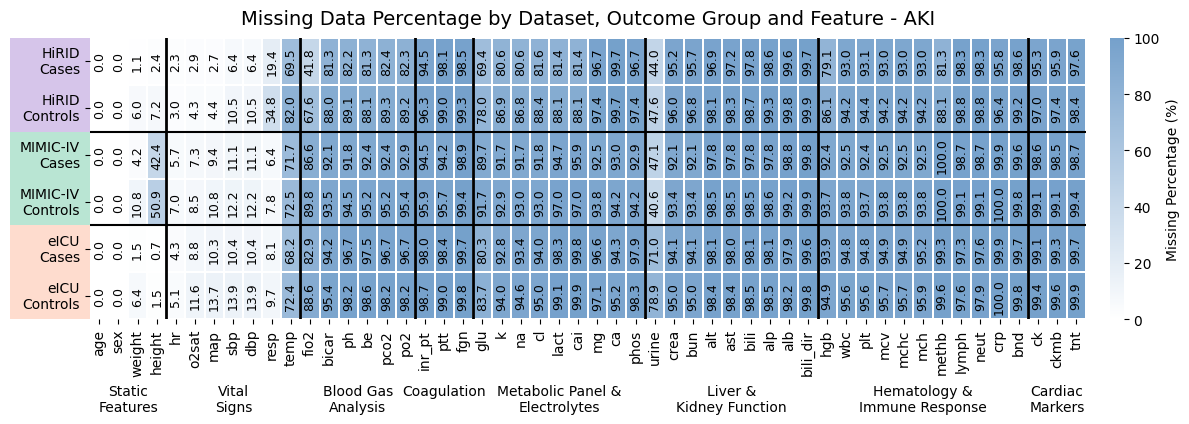

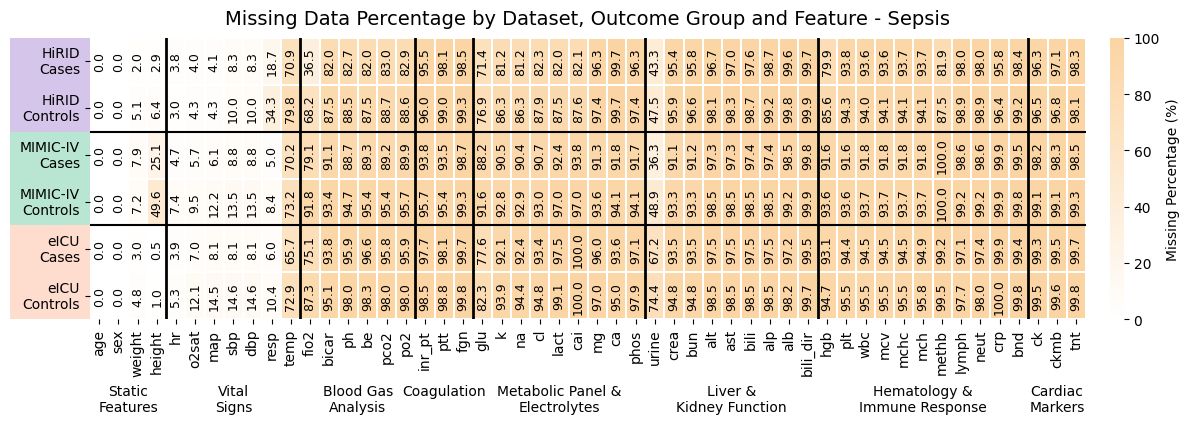

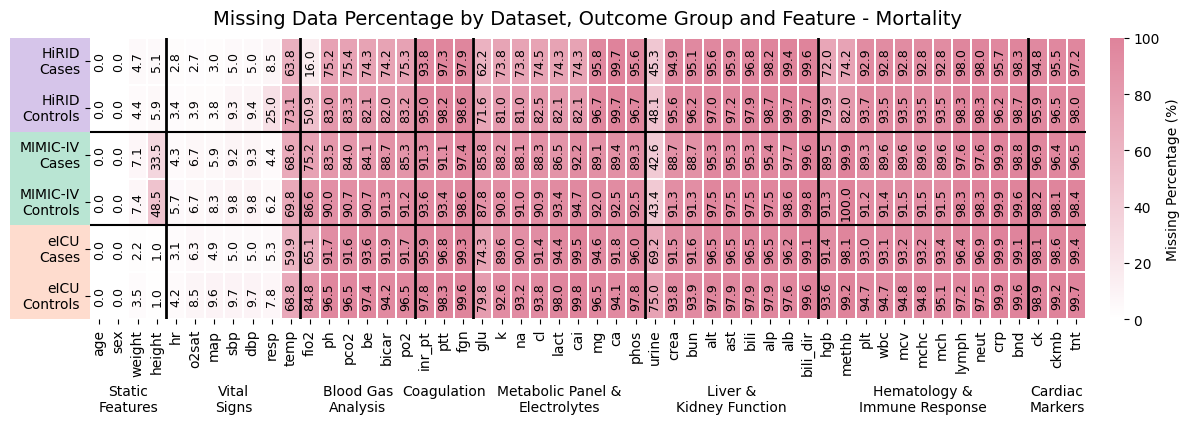

Displaying figure: aki_missing_data


<Figure size 640x480 with 0 Axes>

Displaying figure: sepsis_missing_data


<Figure size 640x480 with 0 Axes>

In [39]:
# Execute visualization generation (Cave: running the full eda will take ca. 60 minutes )
figures = run_eda_and_save_figures(df_dict)

# Display all figures in the figures dictionary
for fig_name, fig in figures.items():
    print(f"Displaying figure: {fig_name}")
    plt.figure(fig.number)
    plt.show()

# Statistics

In [ ]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format  # Format float values to two decimal places

# Create basic summary statistics for all three tasks
def create_basic_summary_table(df_dict):
    """Create a basic summary table for all tasks showing counts and percentages."""
    summary_data = []
    
    for task_name, df in df_dict.items():
        # Get unique stays only (remove duplicates by stay_id)
        df_unique = df.drop_duplicates(subset=['stay_id'])
        
        # Group by dataset
        for dataset in df_unique['dataset'].unique():
            dataset_df = df_unique[df_unique['dataset'] == dataset]
            
            total_stays = len(dataset_df)
            cases = dataset_df[dataset_df['outcome_group'] == 1]
            controls = dataset_df[dataset_df['outcome_group'] == 0]
            
            # Basic statistics
            male_count = (dataset_df['sex'] == 'Male').sum()
            female_count = (dataset_df['sex'] == 'Female').sum()
            median_age = dataset_df['age'].median()
            
            summary_data.append({
                'Task': get_task_display_name(task_name),
                'Dataset': get_dataset_display_name(dataset),
                'Total Stays': total_stays,
                'Cases': len(cases),
                'Controls': len(controls),
                'Case Prevalence (%)': round((len(cases) / total_stays) * 100, 1),
                'Males': male_count,
                'Males (%)': round((male_count / total_stays) * 100, 1),
                'Females': female_count,
                'Females (%)': round((female_count / total_stays) * 100, 1),
                'Median Age': round(median_age, 1)
            })
    
    return pd.DataFrame(summary_data)

# Generate basic summary
basic_summary = create_basic_summary_table(df_dict)
print("Basic Summary Statistics:")
print(basic_summary.to_string(index=False))

Basic Summary Statistics:
     Task  Dataset  Total Stays  Cases  Controls  Case Prevalence (%)  Males  Males (%)  Females  Females (%)  Median Age
      AKI    HiRID        31771   7383     24388                23.20  20361      64.10    11410        35.90       65.00
      AKI MIMIC-IV        62818  26203     36615                41.70  34649      55.20    28169        44.80       65.00
      AKI     eICU       164882  62313    102569                37.80  88259      53.50    76552        46.40       65.00
Mortality    HiRID        12859   1097     11762                 8.50   8245      64.10     4614        35.90       65.00
Mortality MIMIC-IV        49523   3584     45939                 7.20  27924      56.40    21599        43.60       65.00
Mortality     eICU       113381   6253    107128                 5.50  61378      54.10    51972        45.80       66.00
   Sepsis    HiRID        29698   1858     27840                 6.30  19037      64.10    10661        35.90       65.0

In [ ]:
def calculate_bmi(weight, height):
    """Calculate BMI from weight and height."""
    height_m = height / 100 if height > 3 else height
    if pd.isna(weight) or pd.isna(height) or height_m <= 0:
        return float('nan')
    return weight / (height_m ** 2)

def categorize_age(age):
    """Categorize age into groups."""
    bins = [18, 65, 75, 91]
    labels = ['18-64 Years', '65-74 Years', '75-91 Years']
    return pd.cut(age, bins=bins, labels=labels, right=False) 
# each bin is inclusive of the left edge and exclusive of the right edge, except for the last bin which is inclusive of both edges

def categorize_bmi(bmi):
    """Categorize BMI into specified string groups."""
    if pd.isna(bmi):
        return 'Unknown'
    elif bmi < 18.5:
        return 'BMI < 18.5 kg/m2'
    elif bmi < 25:
        return 'BMI 18.5-25 kg/m2'
    elif bmi < 30:
        return 'BMI 25-30 kg/m2'
    else:
        return 'BMI > 30 kg/m2'

def format_stats(count, total, case_count):
    """Format statistics as count (percentage) and case count (case percentage)."""
    percentage = round((count / total) * 100, 1)
    case_percentage = round((case_count / count) * 100, 1) if count > 0 else 0
    return (f"{count:,d} ({percentage}%)", 
            f"{case_count:,d} ({case_percentage}%)")

def create_detailed_task_summary(df, task_name):
    """Create detailed summary for a single task."""
    # Get unique stays only
    df_unique = df.drop_duplicates(subset=['stay_id'])

    # Calculate BMI and create categories
    df_unique = df_unique.copy()
    df_unique['bmi'] = df_unique.apply(
        lambda x: calculate_bmi(x['weight'], x['height']), axis=1
    )
    df_unique['age_group'] = categorize_age(df_unique['age'])
    df_unique['bmi_category'] = df_unique['bmi'].apply(categorize_bmi)

    detailed_stats = []

    for dataset in get_dataset_order():
        if dataset not in df_unique['dataset'].unique():
            continue

        dataset_data = df_unique[df_unique['dataset'] == dataset]
        total_stays = len(dataset_data)
        total_cases = (dataset_data['outcome_group'] == 1).sum()

        stats = {
            'Task': get_task_display_name(task_name),
            'Dataset': get_dataset_display_name(dataset),
            'Total Stays': f"{total_stays:,d}",
            'Total Cases': f"{total_cases:,d} ({round(total_cases/total_stays*100, 1)}%)"
        }

        # Gender statistics
        for gender in ['Male', 'Female']:
            gender_data = dataset_data[dataset_data['sex'] == gender]
            count = len(gender_data)
            case_count = (gender_data['outcome_group'] == 1).sum()
            if count > 0:
                stats[f'{gender}'], stats[f'{gender} Cases'] = format_stats(count, total_stays, case_count)
            else:
                stats[f'{gender}'], stats[f'{gender} Cases'] = "0 (0%)", "0 (0%)"

        # Age group statistics
        for age_group in ['18-39 Years', '40-64 Years', '65-74 Years', '75-90 Years']:
            age_data = dataset_data[dataset_data['age_group'] == age_group]
            count = len(age_data)
            case_count = (age_data['outcome_group'] == 1).sum()
            if count > 0:
                stats[f'Age {age_group}'], stats[f'Age {age_group} Cases'] = format_stats(count, total_stays, case_count)
            else:
                stats[f'Age {age_group}'], stats[f'Age {age_group} Cases'] = "0 (0%)", "0 (0%)"

        # BMI category statistics
        for bmi_cat in [
            "BMI < 18.5 kg/m2",
            "BMI 18.5-25 kg/m2",
            "BMI 25-30 kg/m2",
            "BMI > 30 kg/m2",
            "Unknown",
        ]:
            bmi_data = dataset_data[dataset_data['bmi_category'] == bmi_cat]
            count = len(bmi_data)
            case_count = (bmi_data['outcome_group'] == 1).sum()
            if count > 0:
                stats[f'BMI {bmi_cat}'], stats[f'BMI {bmi_cat} Cases'] = format_stats(count, total_stays, case_count)
            else:
                stats[f'BMI {bmi_cat}'], stats[f'BMI {bmi_cat} Cases'] = "0 (0%)", "0 (0%)"

        detailed_stats.append(stats)

    return pd.DataFrame(detailed_stats)

# Create detailed summaries for each task
print("\nDetailed Summary Statistics by Task:")
print("=" * 80)

all_detailed_summaries = []
for task_name in ['mortality', 'aki', 'sepsis']:
    if task_name in df_dict:
        print(f"\n{get_task_display_name(task_name)} Task:")
        print("-" * 40)
        detailed_summary = create_detailed_task_summary(df_dict[task_name], task_name)
        print(detailed_summary.to_string(index=False))
        all_detailed_summaries.append(detailed_summary)

# Combine all detailed summaries
if all_detailed_summaries:
    combined_detailed = pd.concat(all_detailed_summaries, ignore_index=True)
    
    # Save to Excel
    output_path = "./notebook_output/harmonized_datasets_statistics/harmonized_datasets_statistics.xlsx"
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        # Save basic summary
        basic_summary.to_excel(writer, index=False, sheet_name='Basic Summary')
        
        # Save detailed summary
        combined_detailed.to_excel(writer, index=False, sheet_name='Detailed Summary')
        
        # Adjust column widths for both sheets
        for sheet_name in ['Basic Summary', 'Detailed Summary']:
            worksheet = writer.sheets[sheet_name]
            for column in worksheet.columns:
                max_length = 0
                column = [cell for cell in column]
                for cell in column:
                    try:
                        if len(str(cell.value)) > max_length:
                            max_length = len(str(cell.value))
                    except:
                        pass
                adjusted_width = min(max_length + 2, 50)  # Cap at 50 characters
                worksheet.column_dimensions[column[0].column_letter].width = adjusted_width

    # Save as CSV
    csv_output_path = "./notebook_output/harmonized_datasets_statistics/harmonized_datasets_statistics.csv"
    combined_detailed.to_csv(csv_output_path, index=False)

    print(f"\nSummary tables saved to: {output_path}")
    print(f"Detailed summary also saved as CSV to: {csv_output_path}")
    output_path = "./notebook_output/harmonized_datasets_statistics/harmonized_datasets_statistics.xlsx"
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        # Save basic summary
        basic_summary.to_excel(writer, index=False, sheet_name='Basic Summary')
        
        # Save detailed summary
        combined_detailed.to_excel(writer, index=False, sheet_name='Detailed Summary')
        
        # Adjust column widths for both sheets
        for sheet_name in ['Basic Summary', 'Detailed Summary']:
            worksheet = writer.sheets[sheet_name]
            for column in worksheet.columns:
                max_length = 0
                column = [cell for cell in column]
                for cell in column:
                    try:
                        if len(str(cell.value)) > max_length:
                            max_length = len(str(cell.value))
                    except:
                        pass
                adjusted_width = min(max_length + 2, 50)  # Cap at 50 characters
                worksheet.column_dimensions[column[0].column_letter].width = adjusted_width
    
    print(f"\nSummary tables saved to: {output_path}")


Detailed Summary Statistics by Task:

Mortality Task:
----------------------------------------
     Task  Dataset Total Stays  Total Cases           Male   Male Cases         Female Female Cases Age 18-39 Years Age 18-39 Years Cases Age 40-64 Years Age 40-64 Years Cases Age 65-74 Years Age 65-74 Years Cases Age 75-90 Years Age 75-90 Years Cases BMI BMI < 18.5 kg/m2 BMI BMI < 18.5 kg/m2 Cases BMI BMI 18.5-25 kg/m2 BMI BMI 18.5-25 kg/m2 Cases BMI BMI 25-30 kg/m2 BMI BMI 25-30 kg/m2 Cases BMI BMI > 30 kg/m2 BMI BMI > 30 kg/m2 Cases    BMI Unknown BMI Unknown Cases
Mortality    HiRID      12,859 1,097 (8.5%)  8,245 (64.1%)   679 (8.2%)  4,614 (35.9%)   418 (9.1%)      988 (7.7%)             59 (6.0%)   4,497 (35.0%)            350 (7.8%)   3,380 (26.3%)            328 (9.7%)          0 (0%)                0 (0%)           312 (2.4%)                 34 (10.9%)         5,397 (42.0%)                  450 (8.3%)       4,375 (34.0%)                391 (8.9%)      2,004 (15.6%)               16